In [717]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

stock_ticket = "PCH"
start = datetime.datetime(2012,1,1)
end = datetime.datetime(2022,7,22)
df = web.DataReader(stock_ticket,"yahoo",start,end)
df.drop(columns=['Adj Close'], inplace=True)
df.head()
print(df)
#639 rows

                 High        Low       Open      Close    Volume
Date                                                            
2012-01-03  31.930000  31.230000  31.680000  31.459999  212500.0
2012-01-04  31.379999  30.770000  31.170000  31.090000  230500.0
2012-01-05  31.520000  30.840000  31.040001  31.250000  253300.0
2012-01-06  31.580000  30.940001  31.270000  31.480000  236800.0
2012-01-09  31.700001  31.090000  31.549999  31.170000  228000.0
...               ...        ...        ...        ...       ...
2022-07-18  45.630001  44.500000  45.410000  44.880001  338100.0
2022-07-19  46.439999  45.560001  46.049999  45.980000  419600.0
2022-07-20  46.919998  45.439999  45.619999  46.759998  402400.0
2022-07-21  47.099998  46.389999  46.630001  47.060001  300200.0
2022-07-22  47.529999  46.570000  47.340000  46.799999  279800.0

[2656 rows x 5 columns]


In [701]:
# delete
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
stock_ticket = "SPX"
df = pd.read_csv('/Users/ningxuying/Desktop/SPX.csv')
df_copy = df
df['Date'] = [datetime.datetime.strptime(item,'%Y-%m-%d') for item in df['Date']]
df.set_index('Date',inplace = True)
df.drop(columns=['Adj Close'], inplace=True)
df.head()

,High,Low,Open,Close,Volume
Date,,,,,
2012-01-03,1284.619995,1258.859985,1258.859985,1277.060059,3943710000
2012-01-04,1278.729980,1268.099976,1277.030029,1277.300049,3592580000
2012-01-05,1283.050049,1265.260010,1277.300049,1281.060059,4315950000
2012-01-06,1281.839966,1273.339966,1280.930054,1277.810059,3656830000
2012-01-09,1281.989990,1274.550049,1277.829956,1280.699951,3371600000


In [691]:
import numpy as np
data = df
data = data.values

In [692]:
from sklearn.preprocessing import MinMaxScaler
x_sc = MinMaxScaler()
train_set = x_sc.fit_transform(df.values)
y_sc = MinMaxScaler()
y_set = y_sc.fit_transform(df['Close'].values.reshape(-1,1))

In [693]:
training_set_len = int(np.ceil(len(df)*0.8))
training_set_scaled = train_set[:training_set_len]
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i])
    y_train.append(training_set_scaled[i, 3])
X_train, y_train = np.array(X_train), np.array(y_train)

# print(X_train)
# X_train.shape

In [686]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense 

In [687]:
model = Sequential()

model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
65/65 [==============================] - 50s 71ms/step - loss: 0.0053
Epoch 2/50
65/65 [==============================] - 4s 68ms/step - loss: 0.0015
Epoch 3/50
65/65 [==============================] - 4s 69ms/step - loss: 0.0013
Epoch 4/50
65/65 [==============================] - 4s 69ms/step - loss: 0.0013
Epoch 5/50
65/65 [==============================] - 5s 73ms/step - loss: 0.0013
Epoch 6/50
65/65 [==============================] - 5s 73ms/step - loss: 0.0014
Epoch 7/50
65/65 [==============================] - 4s 66ms/step - loss: 0.0011
Epoch 8/50
65/65 [==============================] - 4s 68ms/step - loss: 9.3699e-04
Epoch 9/50
65/65 [==============================] - 4s 67ms/step - loss: 9.5777e-04
Epoch 10/50
65/65 [==============================] - 4s 67ms/step - loss: 9.0506e-04
Epoch 11/50
65/65 [==============================] - 4s 67ms/step - loss: 8.4167e-04
Epoch 12/50
65/65 [==============================] - 4s 67ms/step - loss: 8.2162e-04
Epoch 13/50
65/6

In [694]:
#For Backtest，没有新预测值，给出metrics参数
X_test = []
y_test = []
test_set_scaled = train_set[training_set_len-60:]
for i in range(60, len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i])
    y_test.append(test_set_scaled[i,3])
X_test = np.array(X_test)
# print(X_test)
predictions = model.predict(X_test)
import sklearn.metrics as metrics
print("Metrics")
print("Normalized MSE:",metrics.mean_squared_error(y_test,predictions))
print("Normalized MAE:",metrics.mean_absolute_error(y_test,predictions))
print("Normalized Explained variance Score:",metrics.explained_variance_score(y_test,predictions))
predictions = y_sc.inverse_transform(predictions)
predictions = [item[0] for item in predictions]
data = df.filter(['Close'])
valid = data[training_set_len:]
valid['Predictions'] = predictions
print("Without Normalization Mean Absolute Percentage Error:",metrics.mean_absolute_percentage_error(valid['Close'] ,valid['Predictions'] ))
daily_pred_accuracy = metrics.mean_absolute_percentage_error(valid['Close'] ,valid['Predictions'] )

17/17 [==============================] - 1s 24ms/step
Metrics
Normalized MSE: 0.0043973244540968974
Normalized MAE: 0.05776899417179154
Normalized Explained variance Score: 0.930564910774735
Without Normalization Mean Absolute Percentage Error: 0.0497714401232603


<ipython-input-694-936552ea3056>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


In [696]:
#backtest 2
print("Backtest Result")
invest_length = len(predict_price)
real_price = df['Close'][training_set_len-1:]
real_open_price = df['Open'][training_set_len-1:]
print("Invest Length:",invest_length,"Days")
list(predict_price).insert(0,df['Close'][training_set_len-1])
# print(df.iloc[training_set_len-1].name)
buy = []
net_return = 0
right_decision=0
#预测出来下一天涨，就买入
for i in range(1,len(predict_price)):
    if predict_price[i] > predict_price[i-1]:
        buy.append(valid.iloc[i].name)
        net_return = net_return + (real_price[i+1]-real_open_price[i])
        if real_price[i] > real_price[i-1]:
            right_decision = right_decision+1
print("Total Investment Times:",len(buy),"\nTimes That has the Right Decision:",right_decision,"\nRate of the Right Decision:",right_decision/len(buy))
# print(buy)
print("Net Return:",net_return)
return_rate = net_return/real_open_price[0]
print("Return Rate:",return_rate)

Backtest Result
Invest Length: 173 Days
Total Investment Times: 58 
Times That has the Right Decision: 31 
Rate of the Right Decision: 0.5344827586206896
Net Return: -197.420166015625
Return Rate: -0.0642844650361158


In [697]:
#For Prediction for the next day's price
scaled_data = train_set
test_data = scaled_data[training_set_len-60:]
nd_X_test = [test_data[len(test_data)-60:len(test_data)]]
nd_X_test = np.array(nd_X_test)
nd_predictions = model.predict(nd_X_test)
nd_predictions = y_sc.inverse_transform(nd_predictions)
print("Next Day Prediction:",nd_predictions[0])

1/1 [==============================] - 0s 31ms/step
Next Day Prediction: [3776.932]


<ipython-input-702-f7c5a54b4d2f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


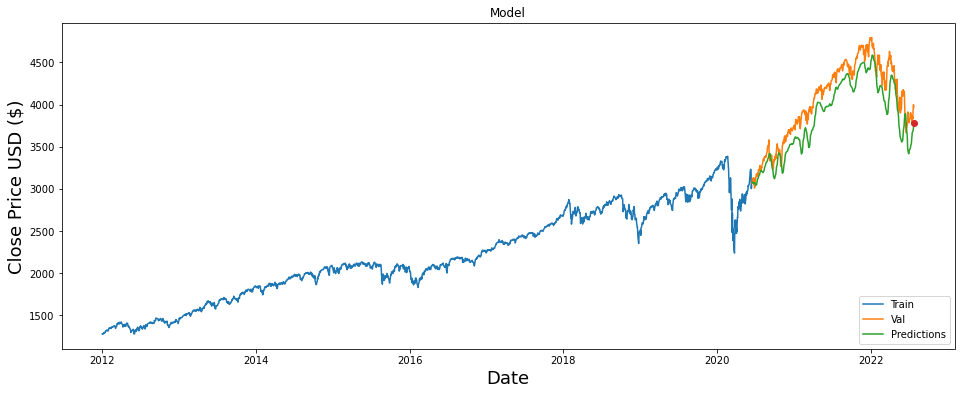

In [702]:
import matplotlib.pyplot as plt
data = df.filter(['Close'])
train = data[:training_set_len]
valid = data[training_set_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train)
plt.plot(valid[['Close', 'Predictions']])
plt.plot([df.iloc[-1].name+datetime.timedelta(days=1)],[nd_predictions[0]],'o')
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt_path = '/Users/ningxuying/Desktop/Pic/'+str(stock_ticket)+'1.png'
plt.savefig(plt_path)
plt.show()

In [703]:
data = df['Close']
dataset = data.values
dataset = dataset.reshape(-1,1)
sc = MinMaxScaler(feature_range=(0,1))
scaled_data= sc.fit_transform(dataset)
training_set_scaled = scaled_data[:training_set_len]
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [704]:
model = Sequential()

model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
65/65 [==============================] - 60s 96ms/step - loss: 0.0069
Epoch 2/50
65/65 [==============================] - 5s 71ms/step - loss: 0.0015
Epoch 3/50
65/65 [==============================] - 4s 69ms/step - loss: 0.0014
Epoch 4/50
65/65 [==============================] - 5s 77ms/step - loss: 0.0017
Epoch 5/50
65/65 [==============================] - 5s 71ms/step - loss: 0.0011
Epoch 6/50
65/65 [==============================] - 5s 79ms/step - loss: 0.0011
Epoch 7/50
65/65 [==============================] - 4s 69ms/step - loss: 0.0012
Epoch 8/50
65/65 [==============================] - 4s 68ms/step - loss: 0.0011
Epoch 9/50
65/65 [==============================] - 4s 67ms/step - loss: 0.0010
Epoch 10/50
65/65 [==============================] - 4s 68ms/step - loss: 9.3874e-04
Epoch 11/50
65/65 [==============================] - 4s 68ms/step - loss: 8.4273e-04
Epoch 12/50
65/65 [==============================] - 4s 69ms/step - loss: 8.8130e-04
Epoch 13/50
65/65 [=====

In [705]:
pp_test_data = scaled_data[len(df)-60:len(df)]
pp_X_test = []
pp_predictions = []
predict_length = 30
test_data = scaled_data[training_set_len-60:]
_X_test = [test_data[len(test_data)+1-60:len(test_data)+1]]
for i in range(predict_length):
    pp_X_test=pp_test_data[i:i+60]
    pp_X_test = np.array(pp_X_test)
    pp_X_test = np.reshape(pp_X_test, (1, 60, 1))
    pp_prediction = model.predict(pp_X_test)
    pp_prediction = pp_prediction[0]
    pp_test_data = np.insert(pp_test_data,-1,pp_prediction)
    pp_predictions.append(pp_prediction) 
    
pp_predictions = sc.inverse_transform(pp_predictions)
f_pred = [item[0] for item in pp_predictions]

1/1 [==============================] - 0s 35ms/step


<ipython-input-706-979fbcb5c44b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


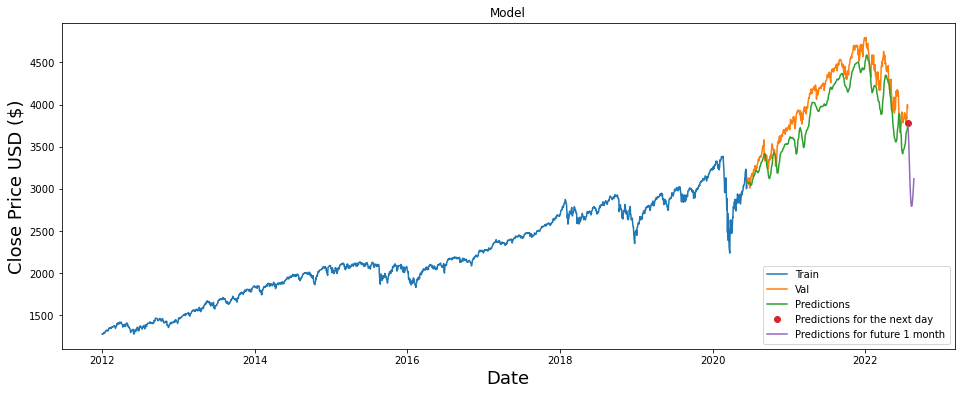

In [706]:
import matplotlib.pyplot as plt
data = df.filter(['Close'])
train = data[:training_set_len]
valid = data[training_set_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train)
plt.plot(valid[['Close', 'Predictions']])
date_index = [df.iloc[-1].name+datetime.timedelta(days=i) for i in range(1,predict_length+1)]
f_pred = pd.DataFrame(f_pred,index = date_index,columns=['Prediction Pirce'])
plt.plot([df.iloc[-1].name+datetime.timedelta(days=1)],[nd_predictions[0]],'o')
plt.plot(f_pred)
plt.legend(['Train', 'Val', 'Predictions','Predictions for the next day','Predictions for future 1 month'], loc='lower right')
plt_path = '/Users/ningxuying/Desktop/Pic/'+str(stock_ticket)+'30r.png'
plt.savefig(plt_path)
plt.show()

In [707]:
pp_test_data = scaled_data[training_set_len-60:training_set_len]
pp_X_test = []
pp_predictions = []
predict_length = 30
for i in range(predict_length):
    pp_X_test=pp_test_data[i:i+60]
    pp_X_test = np.array(pp_X_test)
    pp_X_test = np.reshape(pp_X_test, (1, 60, 1))
    pp_prediction = model.predict(pp_X_test)
    pp_prediction = pp_prediction[0]
    pp_test_data = np.insert(pp_test_data,-1,pp_prediction)
    pp_predictions.append(pp_prediction) 
pp_real = data[training_set_len:training_set_len+30]
pp_scaled_real = scaled_data[training_set_len:training_set_len+30]
print("Metrics")
print("MSE:",metrics.mean_squared_error(pp_scaled_real,pp_predictions))
print("MAE:",metrics.mean_absolute_error(pp_scaled_real,pp_predictions))
print("Explained variance Score:",metrics.explained_variance_score(pp_scaled_real,pp_predictions))
pp_predictions = np.array(pp_predictions)
pp_predictions = sc.inverse_transform(pp_predictions.reshape(-1,1))
print("Without Normalization Mean Absolute Percentage Error:",metrics.mean_absolute_percentage_error(pp_real ,pp_predictions ))
period_pred_accuracy = metrics.mean_absolute_percentage_error(pp_real ,pp_predictions )

1/1 [==============================] - 0s 31ms/step
Metrics
MSE: 0.010267705379226767
MAE: 0.08967278164086331
Explained variance Score: -5.440906976611183
Without Normalization Mean Absolute Percentage Error: 0.09914944111007899


In [708]:
import joblib
randomclassifier = joblib.load('/Users/ningxuying/Desktop/model/SentimentAnalysis.model')

In [718]:
#Scraping
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup as soup
import pandas as pd

# Let's pick a company ticker symbol (AMZN for Amazon)
company_ticker = stock_ticket
# Add the ticker symbol to the "finviz" search box url
url = ("http://finviz.com/quote.ashx?t=" + company_ticker.lower())
# Most websites block requests that are without a User-Agent header (these simulate a typical browser)

# Send a Request to the url and return an html file
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

# open and read the request
webpage = urlopen(req).read()

# make a soup using BeautifulSoup from webpage
html = soup(webpage, "html.parser")

# Extract the 'class' = 'fullview-news-outer' from our html code, and create a dataframe from it
news = pd.read_html(str(html), attrs={'class': 'fullview-news-outer'})[0]
# extract the links for each news by finding all the "a" tags and 'class' = 'tab-link-news'
links = []
for a in html.find_all('a', class_="tab-link-news"):
    links.append(a['href'])

# Clean up our news dataframe
news.columns = ['Date', 'News_Headline']
news['Article_Link'] = links

In [710]:
data = news[:5]
data = [data['News_Headline'].iloc[i] for i in range(len(data))]
for i in range(len(data)):
    data[i]=data[i].lower()
data = [' '.join(str(x) for x in data[:])]
countvector = joblib.load('/Users/ningxuying/Desktop/model/countvector.model')
pred_dataset = countvector.transform(data)
sentiment_indicator = randomclassifier.predict(pred_dataset)
sentiment_indicator = sentiment_indicator[0]

In [712]:
if sentiment_indicator == 1 and nd_predictions[0][0] <= df['Close'][-1]:
    print(stock_ticket)
    print("Adjusted Upward!!!")
    print('Original:',nd_predictions[0][0])
    nd_predictions[0][0] =  df['Close'][-1]*(1.01)
    print('Afterward:', nd_predictions[0][0] )
    print('Wait to See 2022-7-24 close price!')

SPX
Adjusted Upward!!!
Original: 3776.932
Afterward: 4001.246
Wait to See 2022-7-24 close price!


In [713]:
if sentiment_indicator == 0 and nd_predictions[0][0] > df['Close'][-1]:
    print("Adjusted Downward!!!")
    print('Original:',nd_predictions[0][0])
    nd_prediction[0][0] =  df['Close'][-1]*(0.99)
    print('Afterward:', nd_prediction[0][0]) 
    print('Wait to See 2022-7-24 close price!')

In [714]:
f_pred.iloc[0]['Prediction Pirce'] = nd_predictions[0][0]
print(f_pred)
data_output = df[['Close','Volume']]
data_output = pd.merge(data_output,f_pred,left_index=True,right_index=True,how='outer')
path = '/Users/ningxuying/Desktop/Data/'+str(stock_ticket)+'.csv'
data_output.to_csv(path)

            Prediction Pirce
2022-07-23       4001.246094
2022-07-24       3726.093696
2022-07-25       3689.457132
2022-07-26       3634.175450
2022-07-27       3566.188320
2022-07-28       3490.299672
2022-07-29       3410.027282
2022-07-30       3328.087572
2022-07-31       3246.671678
2022-08-01       3167.774386
2022-08-02       3093.196015
2022-08-03       3024.593815
2022-08-04       2963.372358
2022-08-05       2910.643157
2022-08-06       2867.225081
2022-08-07       2833.571358
2022-08-08       2809.862396
2022-08-09       2795.925968
2022-08-10       2791.353425
2022-08-11       2795.522564
2022-08-12       2807.675035
2022-08-13       2826.916762
2022-08-14       2852.285912
2022-08-15       2882.784985
2022-08-16       2917.421311
2022-08-17       2955.204840
2022-08-18       2995.166500
2022-08-19       3036.394278
2022-08-20       3078.009307
2022-08-21       3119.186318


In [715]:
#other to save
other_data = {'ticket':[stock_ticket],
    'Backtest Length':[invest_length],
              'Total Investment Times':[len(buy)],
              'Rate of the Right Decision':[right_decision],
              'Backtest Net Return':[net_return],
              "Backtest Return Rate(%)":[return_rate*100],
               "Next Day's Predicted Price":[nd_predictions[0][0]],
              "Daily Stock Price Prediction Accuracy(%)":[100-daily_pred_accuracy*100],
             "30 Day's Stock Price Prediction Accuracy(%)":[100-period_pred_accuracy*100],
             'Expected Net Return in Future 30 Days':[f_pred['Prediction Pirce'][-1]-df['Close'][-1]],
             "Expected Return Rate in Future 30 Days(%)":[(f_pred['Prediction Pirce'][-1]-df['Close'][-1])/df['Close'][-1]*100]}
news_data = {'News Dates':news['Date'][:5],
             'News Headlines':news['News_Headline'][:5],
             'News Links':news['Article_Link'][:5]}
other_data = pd.DataFrame(other_data)
news_data = pd.DataFrame(news_data)
other_data = pd.concat([other_data,news_data],axis = 1,join = 'outer')
od_path = '/Users/ningxuying/Desktop/OD/'+str(stock_ticket)+'.csv'
other_data.to_csv(od_path)